In [1]:
%matplotlib inline

GridSearch with Census Data
===========================


Census dataset. This dataset is a classification problem - given a range
of data about 32,000 individuals, predict whether their annual income is
above or below fifty thousand dollars per year.

For the purposes of this notebook, we shall treat this as a loan
decision problem. We will pretend that the label indicates whether or
not each individual repaid a loan in the past. We will use the data to
train a predictor to predict whether previously unseen individuals will
repay a loan or not. The assumption is that the model predictions are
used to decide whether an individual should be offered a loan.

We will first train a fairness-unaware predictor and show that it leads
to unfair decisions under a specific notion of fairness called
*demographic parity*. We then mitigate unfairness by applying the
`GridSearch`{.sourceCode} algorithm from the Fairlearn package.


Load and preprocess the data set
================================

We download the data set using [fetch\_adult]{.title-ref} function in
[fairlearn.datasets]{.title-ref}. We start by importing the various
modules we\'re going to use:


In [2]:
import pandas as pd
from sklearn import metrics as skm
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from fairlearn.reductions import DemographicParity, ErrorRate, GridSearch
from fairlearn.metrics import (
    MetricFrame, selection_rate, count, plot_model_comparison, selection_rate_difference
)

We can now load and inspect the data by using the
[fairlearn.datasets]{.title-ref} module:


In [3]:
data = fetch_openml(data_id=1590, as_frame=True)
X_raw = data.data
Y = (data.target == ">50K") * 1
X_raw

/Users/zeyuyang/opt/anaconda3/envs/fairml/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


We are going to treat the sex of each individual as a sensitive feature
(where 0 indicates female and 1 indicates male), and in this particular
case we are going separate this feature out and drop it from the main
data. We then perform some standard data preprocessing steps to convert
the data into a format suitable for the ML algorithms


In [4]:
A = X_raw["sex"]
X = X_raw.drop(labels=["sex"], axis=1)
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

Finally, we split the data into training and test sets:


In [5]:
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(
    X_scaled, Y, A, test_size=0.4, random_state=0, stratify=Y
)

# Work around indexing bug
X_train = X_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

Training a fairness-unaware predictor
=====================================

To show the effect of Fairlearn we will first train a standard ML
predictor that does not incorporate fairness. For speed of
demonstration, we use the simple
`sklearn.linear_model.LogisticRegression`{.interpreted-text
role="class"} class:


In [6]:
unmitigated_predictor = LogisticRegression(solver="liblinear", fit_intercept=True)

unmitigated_predictor.fit(X_train, Y_train)

LogisticRegression(solver='liblinear')

We can start to assess the predictor\'s fairness using the
\`MetricFrame\`:


accuracy              0.851820
selection_rate        0.194707
count             19537.000000
dtype: float64
        accuracy  selection_rate    count
sex                                      
Female  0.925960        0.076794   6537.0
Male    0.814538        0.254000  13000.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'count'}, xlabel='sex'>]], dtype=object)

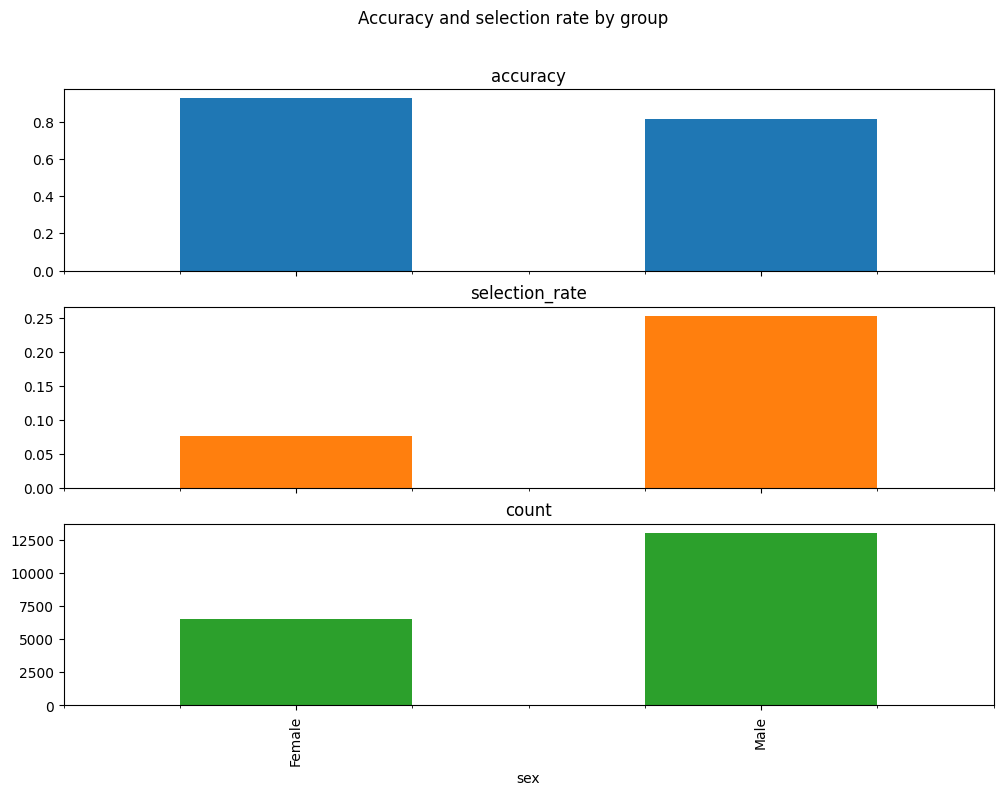

In [7]:
metric_frame = MetricFrame(
    metrics={
        "accuracy": skm.accuracy_score,
        "selection_rate": selection_rate,
        "count": count,
    },
    sensitive_features=A_test,
    y_true=Y_test,
    y_pred=unmitigated_predictor.predict(X_test),
)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 1],
    legend=False,
    figsize=[12, 8],
    title="Accuracy and selection rate by group",
)

Looking at the disparity in accuracy, we see that males have an error
about three times greater than the females. More interesting is the
disparity in opportunity - males are offered loans at three times the
rate of females.

Despite the fact that we removed the feature from the training data, our
predictor still discriminates based on sex. This demonstrates that
simply ignoring a sensitive feature when fitting a predictor rarely
eliminates unfairness. There will generally be enough other features
correlated with the removed feature to lead to disparate impact.


Mitigation with GridSearch
==========================

The `fairlearn.reductions.GridSearch`{.interpreted-text role="class"}
class implements a simplified version of the exponentiated gradient
reduction of [Agarwal et al. 2018](https://arxiv.org/abs/1803.02453).
The user supplies a standard ML estimator, which is treated as a
blackbox. [GridSearch]{.title-ref} works by generating a sequence of
relabellings and reweightings, and trains a predictor for each.

For this example, we specify demographic parity (on the sensitive
feature of sex) as the fairness metric. Demographic parity requires that
individuals are offered the opportunity (are approved for a loan in this
example) independent of membership in the sensitive class (i.e., females
and males should be offered loans at the same rate). We are using this
metric for the sake of simplicity; in general, the appropriate fairness
metric will not be obvious.


In [8]:
sweep = GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)

Our algorithms provide `fit()`{.sourceCode} and `predict()`{.sourceCode}
methods, so they behave in a similar manner to other ML packages in
Python. We do however have to specify two extra arguments to
`fit()`{.sourceCode} - the column of sensitive feature labels, and also
the number of predictors to generate in our sweep.

After `fit()`{.sourceCode} completes, we extract the full set of
predictors from the `fairlearn.reductions.GridSearch`{.interpreted-text
role="class"} object.


In [9]:
sweep.fit(X_train, Y_train, sensitive_features=A_train)

predictors = sweep.predictors_

We could plot performance and fairness metrics of these predictors now.
However, the plot would be somewhat confusing due to the number of
models. In this case, we are going to remove the predictors which are
dominated in the error-disparity space by others from the sweep (note
that the disparity will only be calculated for the sensitive feature;
other potentially sensitive features will not be mitigated). In general,
one might not want to do this, since there may be other considerations
beyond the strict optimization of error and disparity (of the given
sensitive feature).


In [10]:
errors, disparities = [], []
for m in predictors:

    def classifier(X):
        return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame(
    {"predictor": predictors, "error": errors, "disparity": disparities}
)

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

Finally, we can evaluate the dominant models along with the unmitigated
model.


Text(0, 0.5, 'selection rate difference')

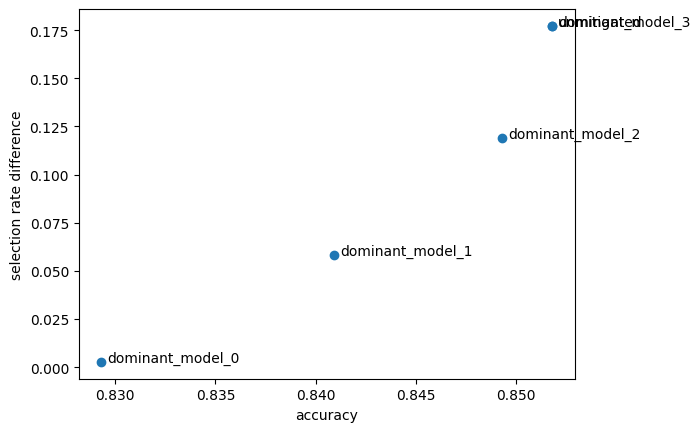

In [11]:
predictions = {"unmitigated": unmitigated_predictor.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": skm.accuracy_score,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=A_test,
        y_true=Y_test,
        y_pred=predictions[key],
    )

import matplotlib.pyplot as plt

x = [metric_frame.overall["accuracy"] for metric_frame in metric_frames.values()]
y = [
    metric_frame.difference()["selection_rate"]
    for metric_frame in metric_frames.values()
]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

We see a Pareto front forming - the set of predictors which represent
optimal tradeoffs between accuracy and disparity in predictions. In the
ideal case, we would have a predictor at (1,0) - perfectly accurate and
without any unfairness under demographic parity (with respect to the
sensitive feature \"sex\"). The Pareto front represents the closest we
can come to this ideal based on our data and choice of estimator. Note
the range of the axes - the disparity axis covers more values than the
accuracy, so we can reduce disparity substantially for a small loss in
accuracy.

In a real example, we would pick the model which represented the best
trade-off between accuracy and disparity given the relevant business
constraints.

\%% \[markdown\] Comparing models easily
\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\--Fairlearn also provides
functionality to compare models much more easily.


No matplotlib.Axes object was provided to draw on, so we create a new one


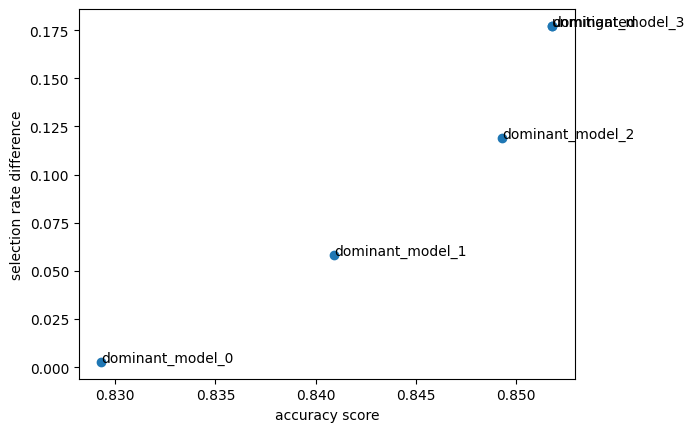

<Axes: xlabel='accuracy score', ylabel='selection rate difference'>

In [12]:
# Plot model comparison
plot_model_comparison(
    x_axis_metric=skm.accuracy_score,
    y_axis_metric=selection_rate_difference,
    y_true=Y_test,
    y_preds=predictions,
    sensitive_features=A_test,
    point_labels=True,
    show_plot=True
)
# End model comparison